In [69]:
import torch
import got_utils
import numpy as np
import pandas as pd
import os
import json
import time


import matplotlib.pyplot as plt

In [101]:
class CodingData:
    def __init__(self, ROOT):
        self.act = torch.from_numpy(np.load(os.path.join(ROOT, 'act.npy'))) # (Samples, Layers, Dim)
        # with open(os.path.join(ROOT, 'labeled_data.json')) as f:
        #     self.data = json.load(f)
        self.data = pd.read_json(os.path.join(ROOT, 'labeled_data.json'))
        self.pcs = []
        for i in range(self.act.shape[1]):
            self.pcs.append(got_utils.get_pcs(self.act.T[:, i, :]))

    def plot_pcs(self, layer):
        scatter = plt.scatter(self.pcs[layer].numpy()[:,0], self.pcs[layer].numpy()[:,1], c=self.data['label'], cmap='tab20')
        # Create legend entries for True and False
        handles, _ = scatter.legend_elements()
        labels = ['False', 'True']
        
        # Add the legend with custom labels
        plt.legend(handles, labels)
        plt.show()

In [102]:
data = CodingData('data/datasets/factual/easy_100')

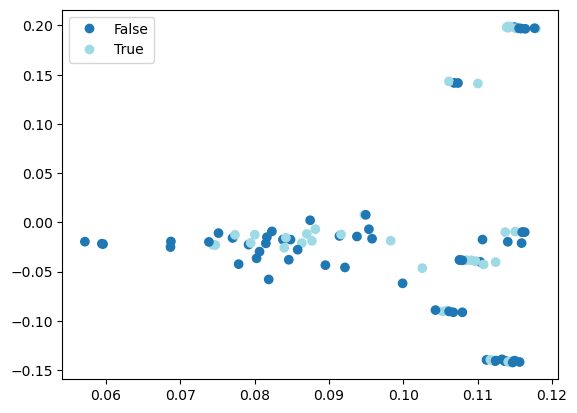

In [103]:
data.plot_pcs(1)

In [99]:
data.data['label'][0]

True

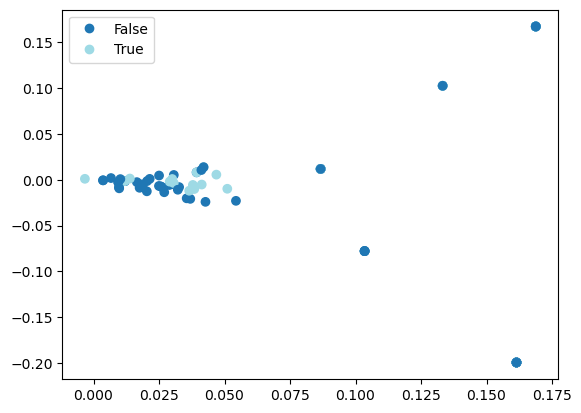

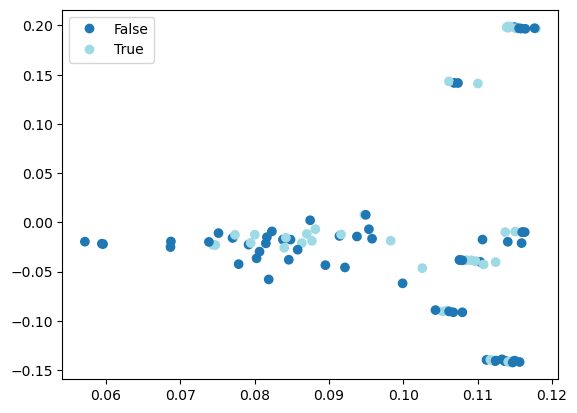

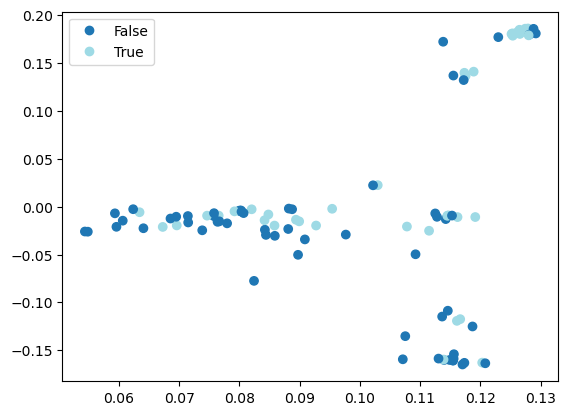

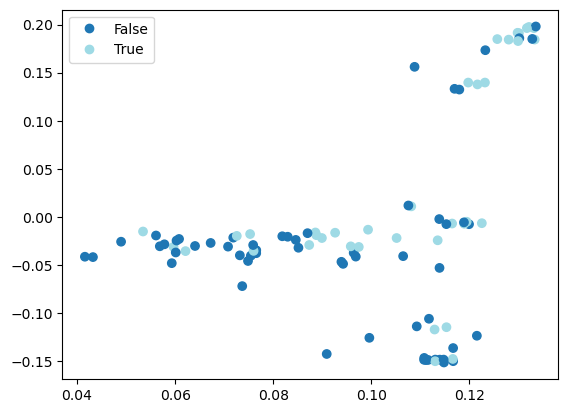

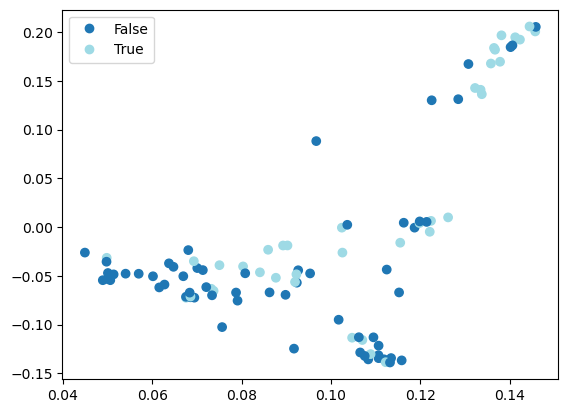

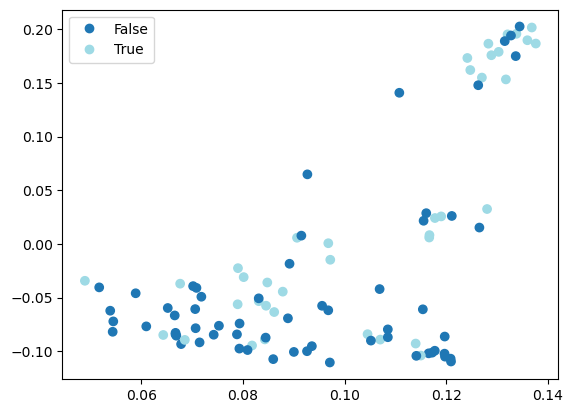

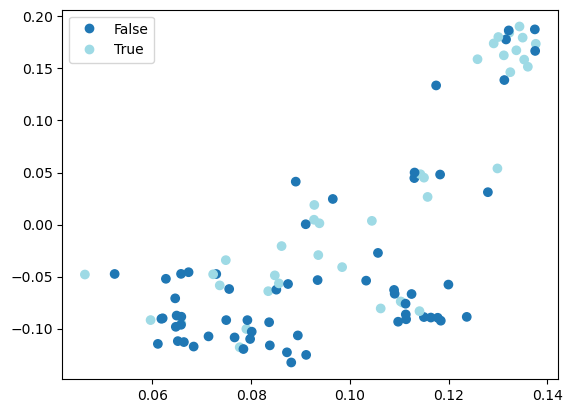

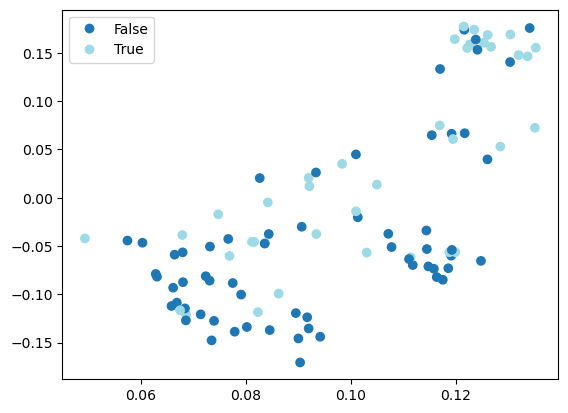

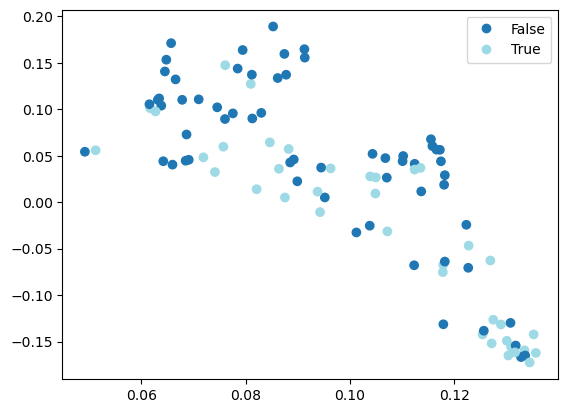

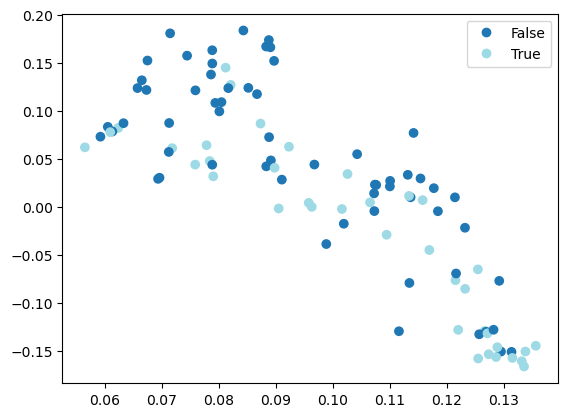

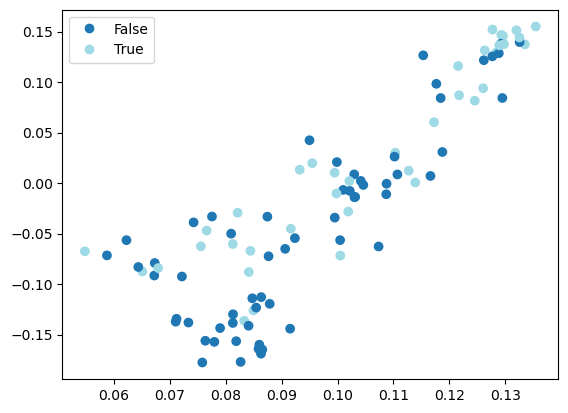

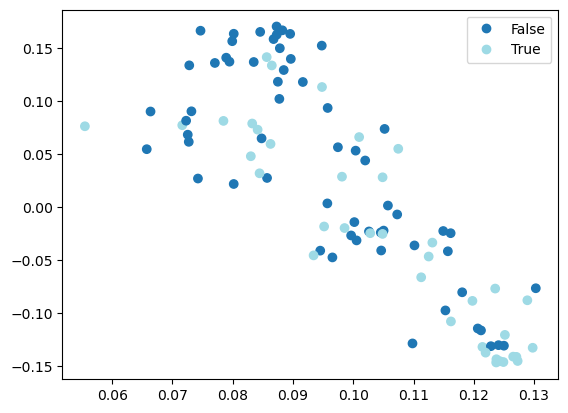

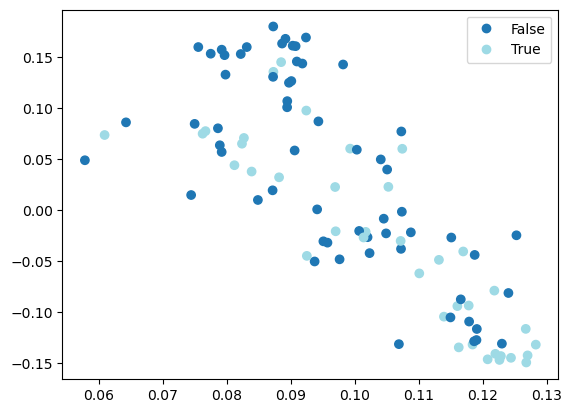

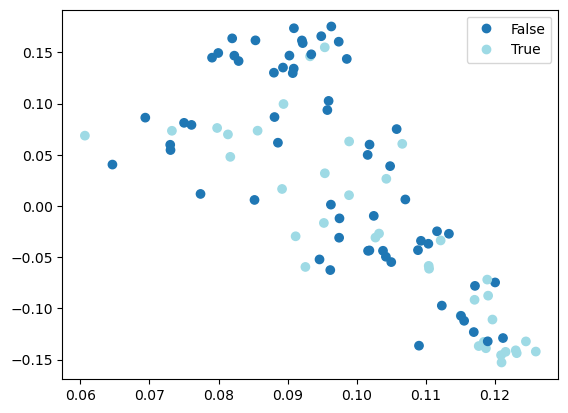

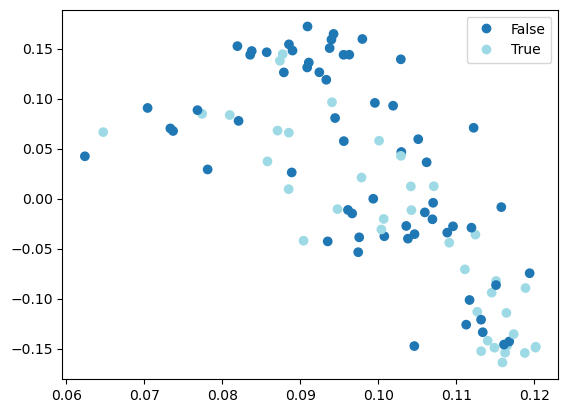

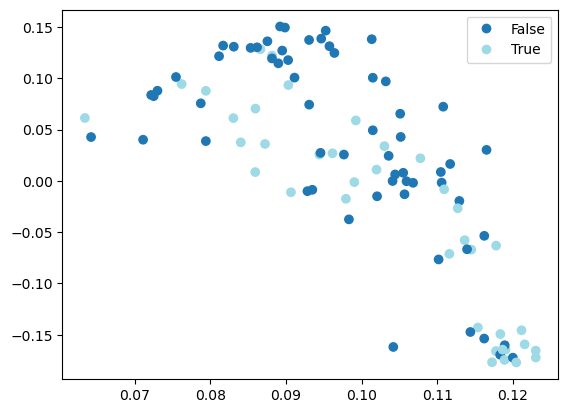

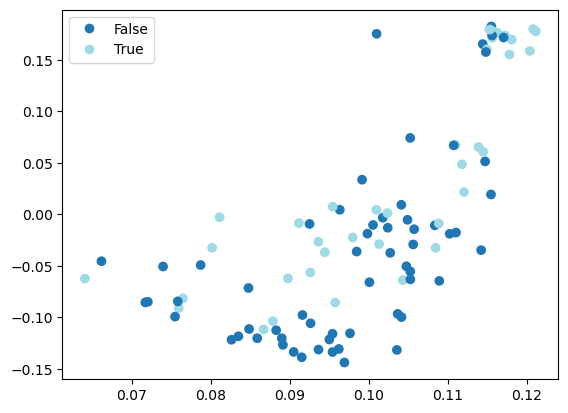

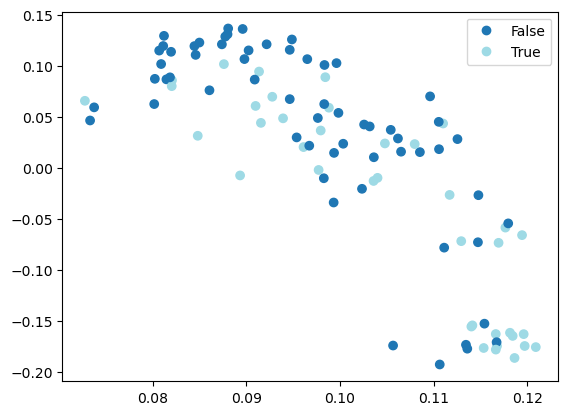

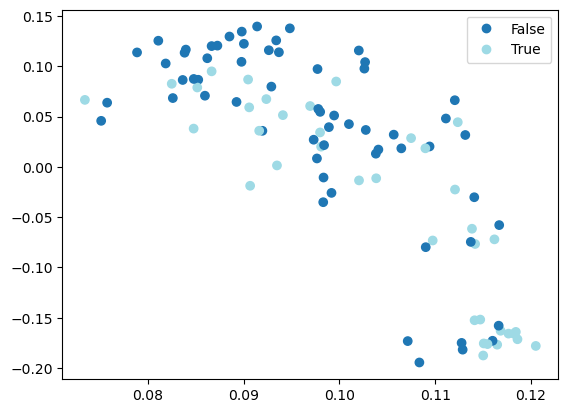

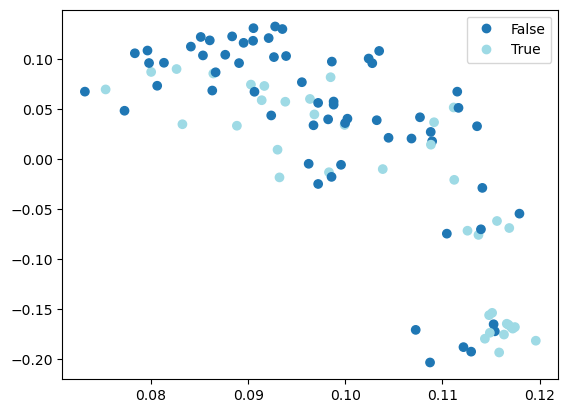

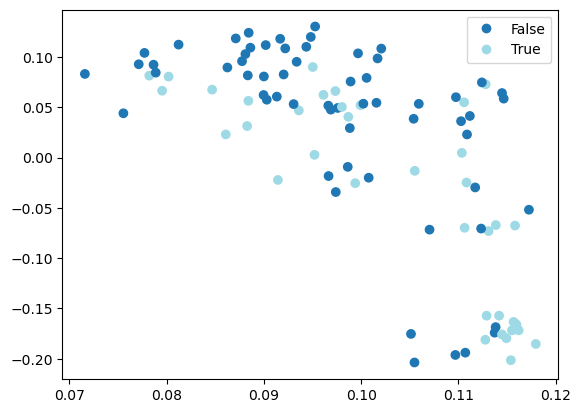

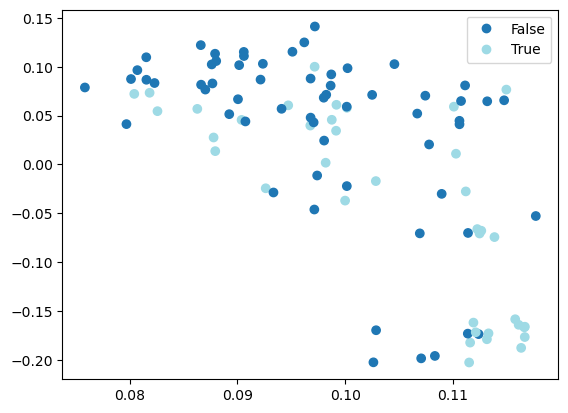

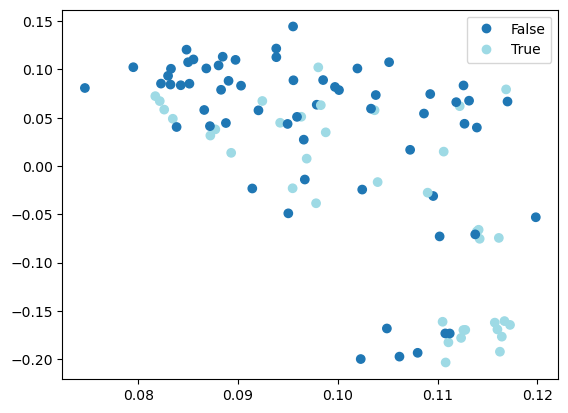

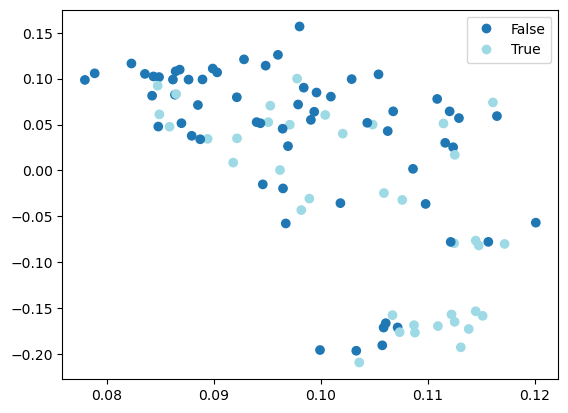

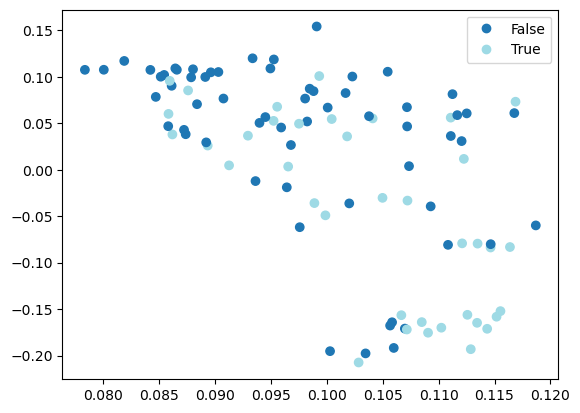

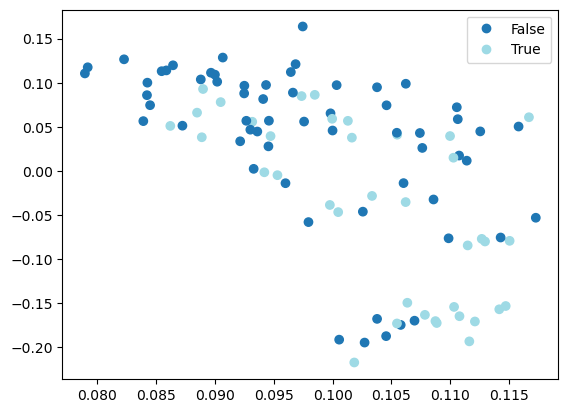

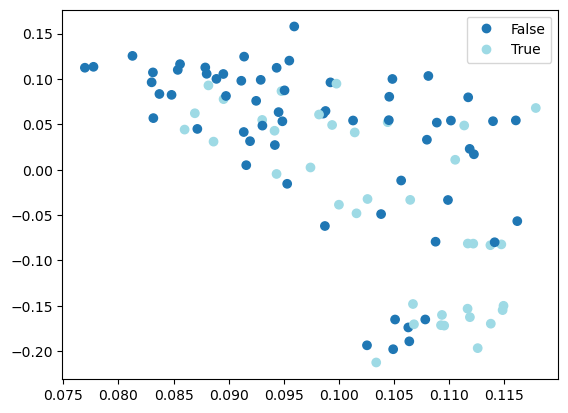

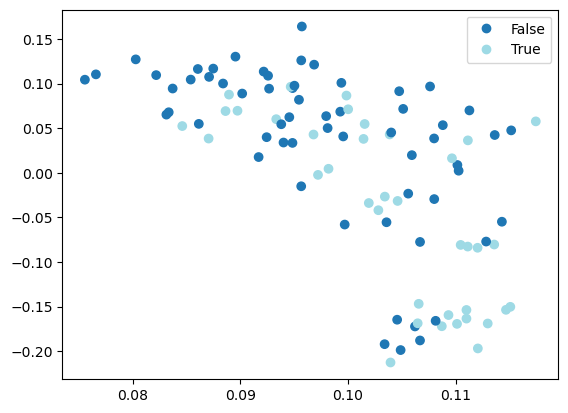

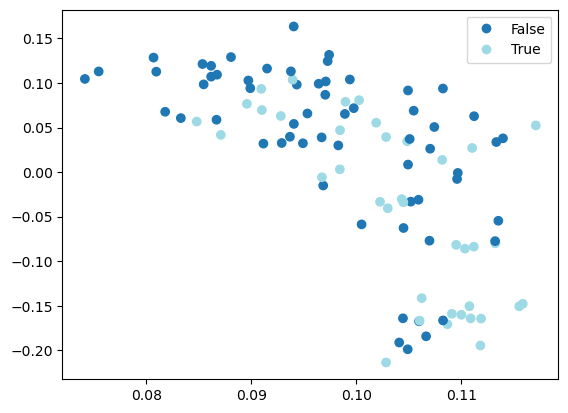

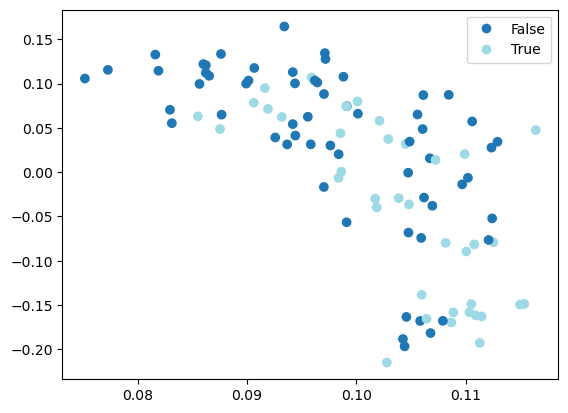

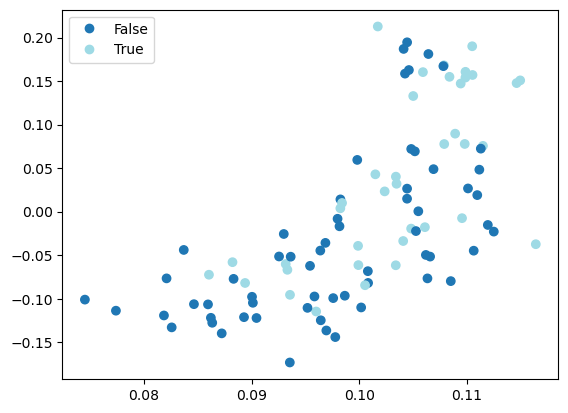

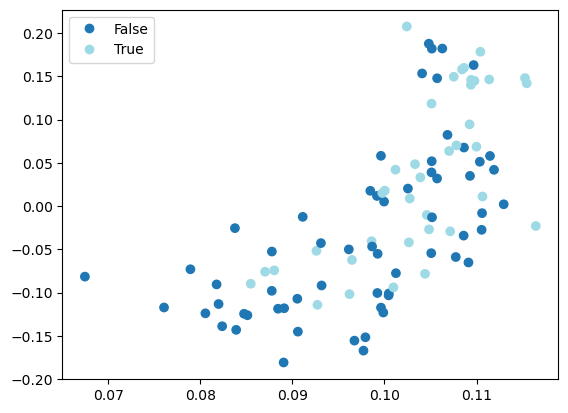

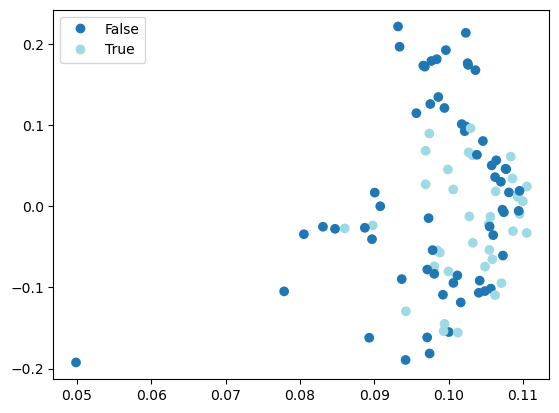

In [104]:
for i in range(33):
    data.plot_pcs(i)
    plt.close()

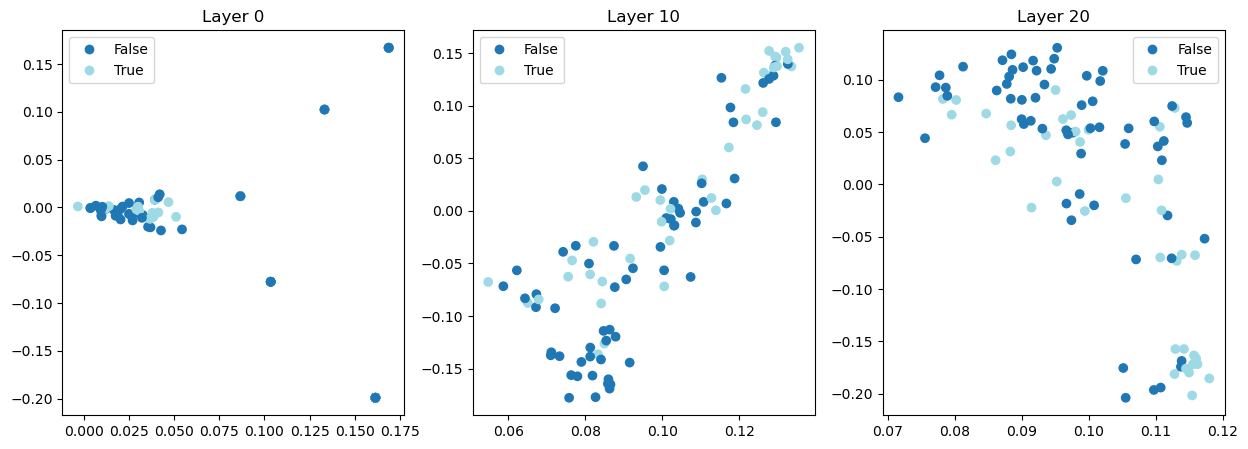

In [105]:
# put 10, 20, 30 in a subplot together
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
for i, ax in enumerate(axs):
    scatter = ax.scatter(data.pcs[10*i].numpy()[:,0], data.pcs[10*i].numpy()[:,1], c=data.data['label'], cmap='tab20')
    ax.set_title(f'Layer {10*i}')
    handles, _ = scatter.legend_elements()
    labels = ['False', 'True']
    ax.legend(handles, labels)